# Реализуем методы для наивного байеса

Сгенерируем выборку, в которой каждый признак имеет некоторое своё распределение, параметры которого отличаются для каждого класса. Затем реализуем несколько методов для класса, который уже частично написан ниже:
- метод predict
- метод \_find\_expon\_params и \_get\_expon\_density для экспоненциального распределения
- метод \_find\_norm\_params и \_get\_norm\_probability для биномиального распределения

Для имплементации \_find\_something\_params изучите документацию функций для работы с этими распределениями в scipy.stats и используйте предоставленные там методы.

In [16]:
import numpy as np
import scipy
import scipy.stats

Сформируем параметры генерации для трех датасетов

In [54]:
func_params_set0 = [(scipy.stats.bernoulli, [dict(p=0.1), dict(p=0.5)]),
                   ]



func_params_set1 = [(scipy.stats.bernoulli, [dict(p=0.1), dict(p=0.5)]),
                    (scipy.stats.expon, [dict(scale=1), dict(scale=0.3)]),
                   ]

func_params_set2 = [(scipy.stats.bernoulli, [dict(p=0.1), dict(p=0.5)]),
                    (scipy.stats.expon, [dict(scale=1), dict(scale=0.3)]),
                    (scipy.stats.norm, [dict(loc=0, scale=1), dict(loc=1, scale=2)]),
                   ]

def generate_dataset_for_nb(func_params_set=[], size = 2500, random_seed=0):
    '''
    Генерирует выборку с заданными параметрами распределений P(x|y).
    Число классов задается длиной списка с параметрами.
    Возвращает X, y, список с названиями распределений
    '''
    np.random.seed(random_seed)

    X = []
    names = []
    for func, params in func_params_set:
        names.append(func.name)
        f = []
        for i, param in enumerate(params):
            f.append(func.rvs(size=size, **param))
        f = np.concatenate(f).reshape(-1,1)
        X.append(f)

    X = np.concatenate(X, 1)
    y = np.array([0] * size + [1] * size)

    shuffle_inds = np.random.choice(range(len(X)), size=len(X), replace=False)
    X = X[shuffle_inds]
    y = y[shuffle_inds]

    return X, y, names 

X, y, distrubution_names = generate_dataset_for_nb(func_params_set0)
X.shape, y.shape, distrubution_names

((5000, 1), (5000,), ['bernoulli'])

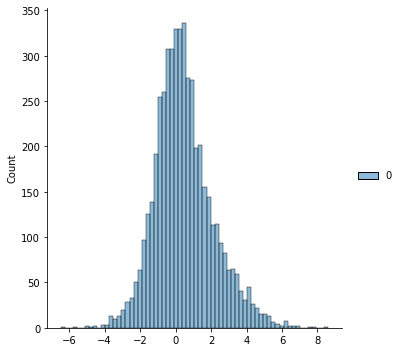

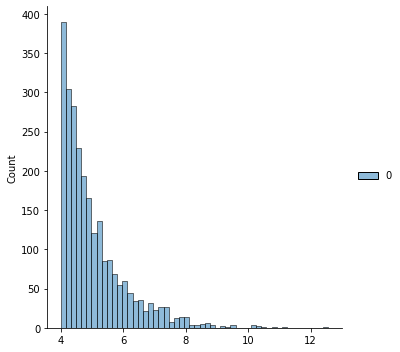

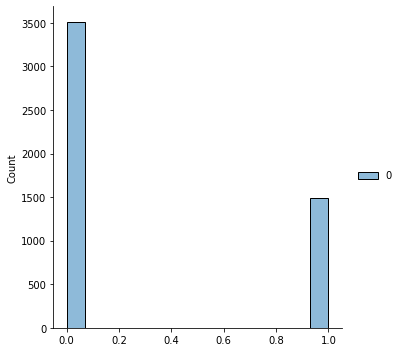

In [64]:
test1= [(scipy.stats.expon, [dict(scale=1)]),
                   ]

test2= [(scipy.stats.norm, [dict(loc=0, scale=1), dict(loc=1, scale=2)]),
]

X, y, distrubution_names = generate_dataset_for_nb(func_params_set0)
X1, y1, distrubution_names = generate_dataset_for_nb(test1)
X2, y2, distrubution_names = generate_dataset_for_nb(test2)

import seaborn as sns
sns.displot(X2)
sns.displot(X1)
sns.displot(X)


In [165]:
from collections import defaultdict
from sklearn.base import BaseEstimator, ClassifierMixin

class NaiveBayes(BaseEstimator, ClassifierMixin):
    '''
    Реализация наивного байеса, которая помимо X, y
    принимает на вход во время обучения 
    виды распределений значений признаков
    '''
    def __init__(self):
        pass
    
    def _find_bernoulli_params(self, x):
        '''
        метод возвращает найденный параметр `p`
        распределения scipy.stats.bernoulli
        '''
        return dict(p=np.mean(x))
    
    def _get_bernoulli_probability(self, x, params):
        '''
        метод возвращает вероятность x для данных
        параметров распределния
        '''
        return scipy.stats.bernoulli.pmf(x, **params)

    def _find_expon_params(self, x):
        # нужно определить параметры распределения  

        # и вернуть их
        return dict(scale=1/scipy.stats.tstd(x),
                    loc=np.min(x))
    
    def _get_expon_density(self, x, params):
        # нужно вернуть плотность распределения в x
        return scipy.stats.expon.pdf(x, **params)


    def _find_norm_params(self, x):
        # нужно определить параметры распределения
        # и вернуть их
        dict(sigma=sum(x-np.mean(x) )^2/(len(x)-1), loc=scipy.stats.tstd(x))

    
    def _get_norm_density(self, x, params):
        # нужно вернуть плотность распределения в x
        return scipy.stats.norm.pdf(x, **params)

    def _get_params(self, x, distribution):
        '''
        x - значения из распределения,
        distribution - название распределения в scipy.stats
        '''
        if distribution == 'bernoulli':
            return self._find_bernoulli_params(x)
        elif distribution == 'expon':
            return self._find_expon_params(x)
        elif distribution == 'norm':
            return self._find_norm_params(x)
        else:
            raise NotImplementedError('Unknown distribution')
            
    def _get_probability_or_density(self, x, distribution, params):
        '''
        x - значения,
        distribytion - название распределения в scipy.stats,
        params - параметры распределения
        '''
        if distribution == 'bernoulli':
            return self._get_bernoulli_probability(x, params)
        elif distribution == 'expon':
            return self._get_expon_density(x, params)
        elif distribution == 'norm':
            return self._get_norm_density(x, params)
        else:
            raise NotImplementedError('Unknown distribution')

    def fit(self, X, y, distrubution_names):
        '''
        X - обучающая выборка,
        y - целевая переменная,
        feature_distributions - список названий распределений, 
        по которым предположительно распределны значения P(x|y)
        ''' 
        assert X.shape[1] == len(distrubution_names)
        assert set(y) == {0, 1}
        self.n_classes = len(np.unique(y))
        self.distrubution_names = distrubution_names
        
        self.y_prior = [(y == j).mean() for j in range(self.n_classes)]
        
        self.distributions_params = defaultdict(dict)
        for i in range(X.shape[1]):
            distribution = self.distrubution_names[i]
            for j in range(self.n_classes):
                # print(j,i)
                values = X[y == j, i]
                # print(X.shape, values.shape)
                # print(values)
                self.distributions_params[j][i] = \
                    self._get_params(values, distribution)
        
        return self.distributions_params
    
    def predict(self, X):
        '''
        X - тестовая выборка
        '''
        print('покажем тестовую выборку:', X)
        assert X.shape[1] == len(self.distrubution_names)
        print('Сосздадим бланк для  ответов, размера ', X.shape)
        preds=np.zeros(X.shape)
        print(preds, preds.shape)
        print('после этого пройдёмся по каждому СТОЛБЦУ')
        for i in range(X.shape[1]):
            # выбираем распределение
            distrubution_name=self.distrubution_names[i]
            print(f'выбираем из списка распределений {self.distrubution_names} распределение {i}: {distrubution_name}')

            # пишем функцию максимального правдоподобия
            print(f'Пишем функцию максимального правдоподобия с входными данными:')
            print('априорная вероятность y = ', self.y_prior)
            print('Названия распределений: ', self.distrubution_names)
            print('параметры распределений :', self.distributions_params)
            print('плотность распределения p(x|y) = ', self._get_probability_or_density( X, distrubution_name, self.distributions_params[i]))
            preds=np.argmax(
                [(np.log(self.y_prior[i]) +
                  np.log(self._get_probability_or_density( X, distrubution_name, self.distributions_params[j][i])))
                for j in range(len(self.y_prior))
                ], axis=0

            )
        # нужно реализовать подсчет аргмаксной формулы, по которой 
        # наивный байес принимает решение о принадлежности объекта классу
        # и применить её для каждого объекта в X
        #
        # примечание: обычно подсчет этой формулы реализуют через 
        # её логарифмирование, то есть, через сумму логарифмов вероятностей, 
        # поскольку перемножение достаточно малых вероятностей будет вести
        # к вычислительным неточностям


        return preds

Проверим результат на примере первого распределения

In [168]:
nb = NaiveBayes()
nb.fit(X, y, ['bernoulli'])

defaultdict(dict, {0: {0: {'p': 0.1128}}, 1: {0: {'p': 0.482}}})

In [170]:
from sklearn.metrics import f1_score

prediction = nb.predict(X)
score = f1_score(y, prediction)
print('{:.2f}'.format(score))

покажем тестовую выборку: [[0]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]
Сосздадим бланк для  ответов, размера  (5000, 1)
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]] (5000, 1)
после этого пройдёмся по каждому СТОЛБЦУ
выбираем из списка распределений ['bernoulli'] распределение 0: bernoulli
Пишем функцию максимального правдоподобия с входными данными:
априорная вероятность y =  [0.5, 0.5]
Названия распределений:  ['bernoulli']
параметры распределений : defaultdict(<class 'dict'>, {0: {0: {'p': 0.1128}}, 1: {0: {'p': 0.482}}})


TypeError: keywords must be strings

# Ответы для формы

Ответом для формы должны служить числа, которые будут выведены ниже. Все ответы проверены: в этих примерах получается одинаковый результат и через сумму логарифмов, и через произведение вероятностей.

In [116]:
scipy.stats.bernoulli.name

for fps in (func_params_set0 * 2,
            func_params_set1, 
            func_params_set2):
    

    X, y, distrubution_names = generate_dataset_for_nb(fps)
    
    nb = NaiveBayes()
    nb.fit(X, y, distrubution_names)
    prediction = nb.predict(X)
    score = f1_score(y, prediction)
    print('{:.2f}'.format(score))

Сосздадим бланк для  ответов, размера  (5000, 2)


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets